In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import Options

import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn.apionly as sns

plt.style.use('clean')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Work with Real Data

In [74]:
aapl = Options('aapl', 'yahoo')
data = aapl.get_all_data()

In [ ]:
data.reset_index(inplace=True)

In [91]:
C = data[data.Type=='call'].pivot('Expiry', 'Strike', 'Last')

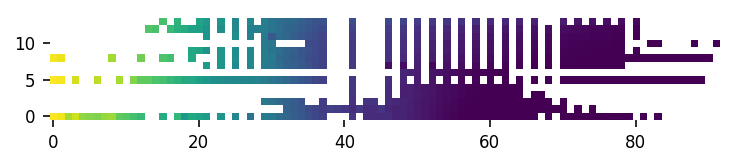

In [92]:
plt.imshow(C.as_matrix(), origin='lower')

In [230]:
aapl.underlying_price

172.67

In [94]:
C_grid = C.dropna(1)
C_grid

Strike,155.0,160.0,165.0,170.0,175.0,180.0,185.0,190.0
Expiry,,,,,,,,
2017-12-15,17.70,12.80,7.83,3.19,0.45,0.04,0.01,0.01
2017-12-22,17.15,12.59,8.12,3.83,1.11,0.22,0.06,0.02
2017-12-29,17.64,12.41,8.35,4.35,1.69,0.50,0.14,0.06
2018-01-05,14.92,13.09,8.80,4.86,2.18,0.80,0.28,0.13
2018-01-12,15.15,12.40,8.95,5.30,2.74,1.22,0.50,0.21
2018-01-19,18.55,13.90,9.63,6.00,3.20,1.56,0.70,0.33
2018-01-26,18.80,14.85,9.90,6.25,3.86,2.01,0.90,0.45
2018-02-16,5.70,15.54,3.30,8.65,6.10,4.05,2.63,1.64
2018-04-20,21.27,17.55,14.16,11.20,8.65,6.52,4.82,3.50


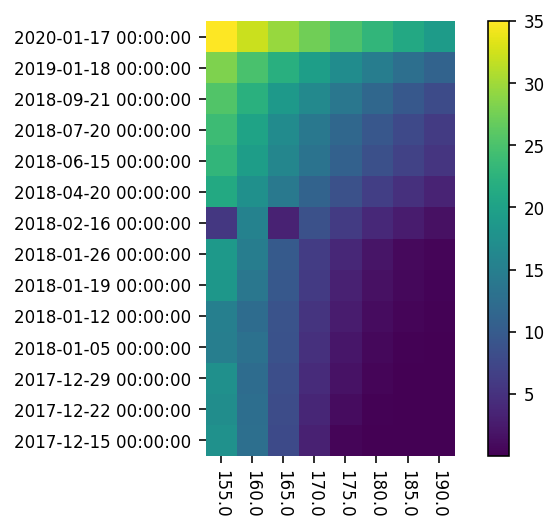

In [99]:
m,n = C_grid.shape
plt.imshow(C_grid.as_matrix(), origin='lower')
plt.yticks(range(m), list(C_grid.index))
plt.xticks(range(n), C_grid.columns, rotation=-90)
plt.colorbar()

In [234]:
from scipy.interpolate import interp2d

In [239]:
C_grid.columns

Float64Index([155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0], dtype='float64', name='Strike')

In [246]:
[d.toordinal() for d in C_grid.index]

[736678,
 736685,
 736692,
 736699,
 736706,
 736713,
 736720,
 736741,
 736804,
 736860,
 736895,
 736958,
 737077,
 737441]

In [308]:
C_interp = interp2d(C_grid.columns, 
                    [d.toordinal() for d in C_grid.index],
                    C_grid.as_matrix(), 
                    kind='cubic', 
                    bounds_error=True)

In [316]:
C_grid.index

DatetimeIndex(['2017-12-15', '2017-12-22', '2017-12-29', '2018-01-05',
               '2018-01-12', '2018-01-19', '2018-01-26', '2018-02-16',
               '2018-04-20', '2018-06-15', '2018-07-20', '2018-09-21',
               '2019-01-18', '2020-01-17'],
              dtype='datetime64[ns]', name='Expiry', freq=None)

In [318]:
C_aug = C_interp(np.linspace(155, 190, 50), np.linspace(736678, 737441, 100))
C_aug = pd.DataFrame(C_aug, columns=np.linspace(155, 190, 50),
                    index=[pd.datetime.fromordinal(int(x)).date() for x in np.linspace(736678, 737441, 100)])

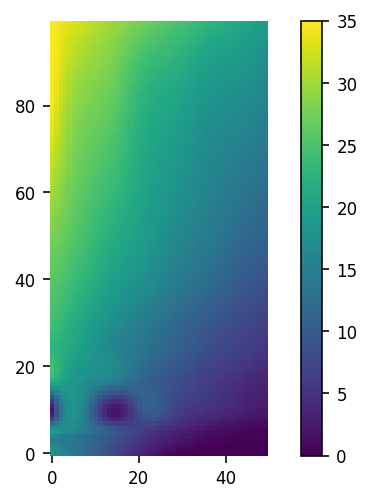

In [319]:
plt.imshow(C_aug.as_matrix(), clim=(0,35),
          origin='lower')
plt.colorbar()

In [10]:
def get_fd_local_vol(C_grid, index_is_dt=False):
    if index_is_dt:
        dts = np.diff(C_grid.index).astype('timedelta64[D]').astype('float') / 252
    else:
        dts = np.diff(C_grid.index)
    dCdt = (C_grid.as_matrix()[1:,:] - C_grid.as_matrix()[:-1,:]) / dts[:,np.newaxis]
    dCdt_compatible = (dCdt[1:,1:-1] + dCdt[:-1,1:-1]) / 2
    #assert len(set(np.diff(C_grid.columns))) == 1
    Kdiff = np.diff(C_grid.columns)[0]
    d2CdK2 = (C_grid.as_matrix()[:,:-2] + C_grid.as_matrix()[:,2:] - 2*C_grid.as_matrix()[:,1:-1]) / Kdiff**2
    d2CdK2_compatible = d2CdK2[1:-1,:]
    
    new_expiries = C_grid.index[1:-1]
    new_strikes = np.array(C_grid.columns[1:-1])
    
    return pd.DataFrame(d2CdK2_compatible, index=new_expiries, columns=new_strikes)


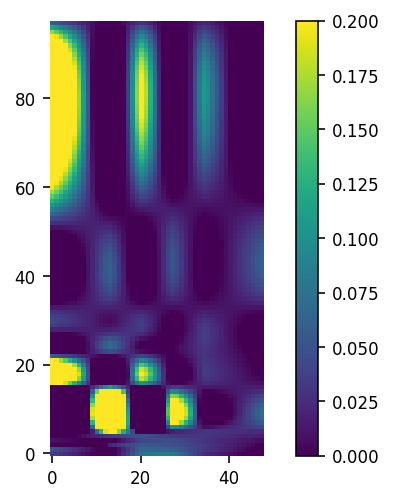

In [322]:
plt.imshow(get_fd_local_vol(C_aug).as_matrix(), origin='lower', clim=(0,.2))
plt.colorbar()

In [165]:
new_strikes

array([ 160.,  165.,  170.,  175.,  180.,  185.])

In [154]:
dCdt_compatible.shape

(12, 6)

In [153]:
d2CdK2_compatible.shape

(12, 6)

In [168]:
local_vols = 2*dCdt_compatible / (new_strikes[np.newaxis,:]**2 * d2CdK2_compatible)

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


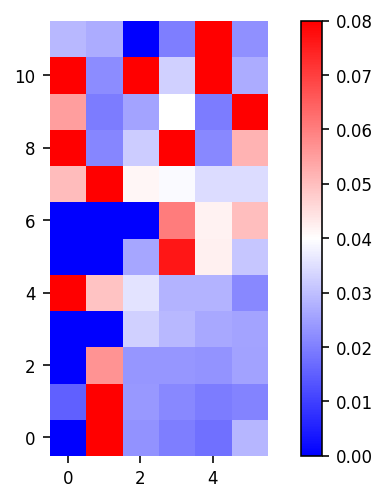

In [187]:
plt.imshow(local_vols, origin='lower', clim=(0,.08), cmap='bwr')
plt.colorbar()

(array([  3.,   9.,  52.,   2.,   2.,   1.,   1.,   0.,   0.,   1.]),
 array([-0.15234375, -0.06681628,  0.0187112 ,  0.10423867,  0.18976615,
         0.27529362,  0.3608211 ,  0.44634857,  0.53187605,  0.61740352,
         0.702931  ]),
 <a list of 10 Patch objects>)

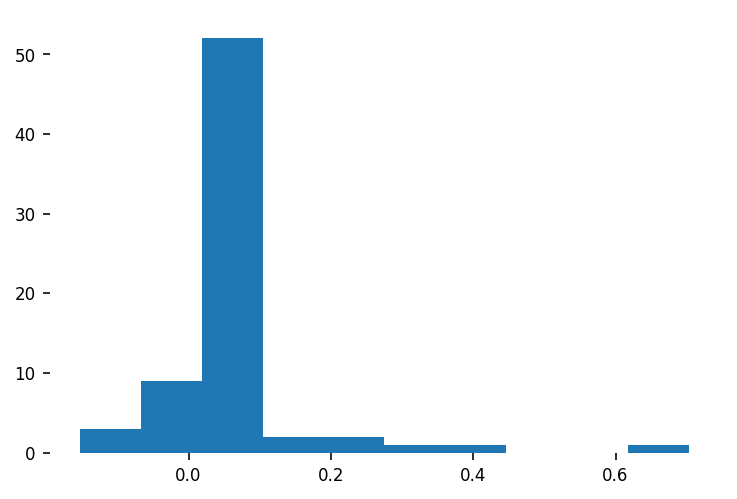

In [233]:
plt.hist(local_vols.flatten()[local_vols.flatten() != np.inf])

In [193]:
%run interpolated_local_vol.py
f = InterpolatedLocalVol(local_vols, new_expiries, new_strikes)

In [227]:
%run report/scripts/sampleendprice.py
%run report/scripts/pricecall.py

In [ ]:
sample_end_price(aapl.underlying_price, f, )

In [195]:
aapl.underlying_price

172.67

In [198]:
aapl.quote_time.date()

datetime.date(2017, 12, 11)

In [216]:
days_to = (new_expiries - pd.Timestamp(aapl.quote_time.date())).days

In [217]:
days_to

Int64Index([11, 18, 25, 32, 39, 46, 67, 130, 186, 221, 284, 403], dtype='int64', name='Expiry')

In [ ]:
for num_days in days_to:
    samples = sample_end_price(aapl.underlying_price, 
                               f, 
                               num_days, 
                               num_days, 
                               int(1e6))
    pxs = price_call(np.array(C_grid.columns), samples)
    print(pxs)
    break

In [221]:
np.array(C_grid.columns)

array([ 155.,  160.,  165.,  170.,  175.,  180.,  185.,  190.])

In [213]:
test = pd.Timedelta('7 days 00:00:00')

In [215]:
test.days

7

# Simulate Data

In [100]:
%run report/scripts/sampleendprice.py
%run report/scripts/pricecall.py
%run interpolated_local_vol.py

In [20]:
def quadratic_vol(px, time):
    return np.clip(.16 + 1e-4*(px-100)**2, 0, .3)

In [99]:
expiries = np.arange(0,5.1,.5)
K = np.arange(0,201,5)

In [21]:
%time samples = sample_end_prices(100, quadratic_vol, expiries, 100, int(1e5))

CPU times: user 11.5 s, sys: 115 ms, total: 11.6 s
Wall time: 11.7 s


In [66]:
pxs = price_calls(K, samples)

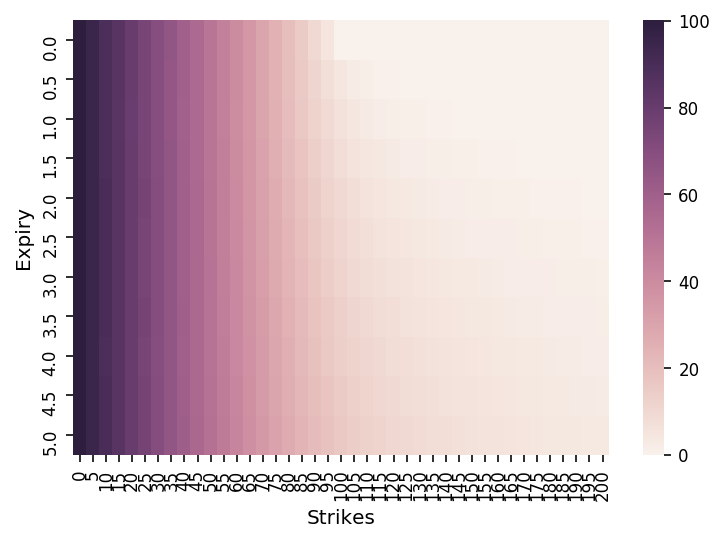

In [67]:
sns.heatmap(pxs)

In [73]:
local_vols = get_fd_local_vol(pxs)

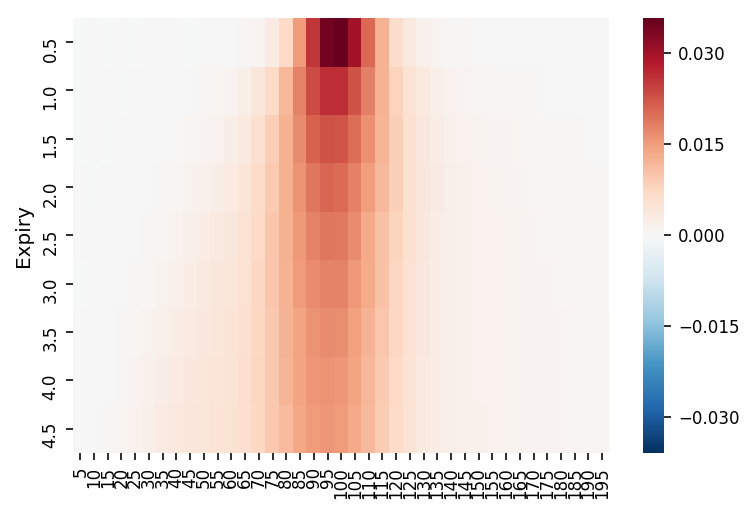

In [74]:
sns.heatmap(local_vols)

In [80]:
f = InterpolatedLocalVol(local_vols.as_matrix().T, local_vols.columns, local_vols.index)

In [81]:
f(np.array([80, 100]), 1)

array([[ 0.01197585],
       [ 0.02650959]])

In [89]:
%time f_samples = sample_end_prices(100, f, np.arange(0,5.1,.5), 8, int(1e5))

CPU times: user 2.97 s, sys: 36.2 ms, total: 3 s
Wall time: 3.03 s


In [84]:
f_pxs = price_calls(K, f_samples)

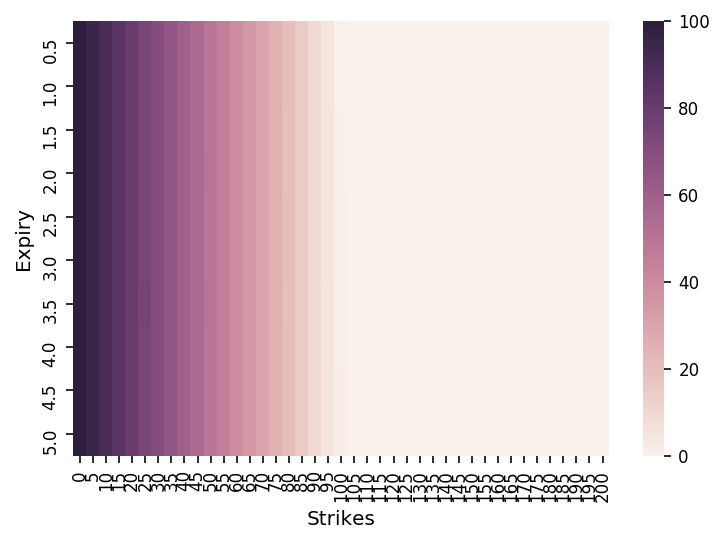

In [85]:
sns.heatmap(f_pxs)

(array([ 204.,   55.,   47.,   31.,   21.,   20.,   12.,    9.,    7.,    4.]),
 array([ -0.1843719 ,   1.28465741,   2.75368671,   4.22271601,
          5.69174531,   7.16077462,   8.62980392,  10.09883322,
         11.56786252,  13.03689183,  14.50592113]),
 <a list of 10 Patch objects>)

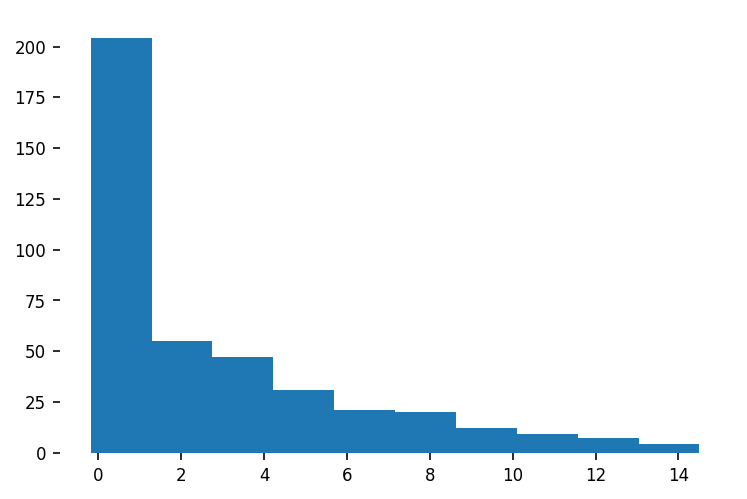

In [98]:
errs = (pxs - f_pxs).as_matrix().flatten()
plt.hist(errs[(np.abs(errs) != np.inf) & (~np.isnan(errs))])

In [101]:
%run report/scripts/sampleendprice.py
%run report/scripts/pricecall.py
%run interpolated_local_vol.py

def test_local_vol_procedure(actual_local_vol, 
                             local_vol_approximator, 
                             K, 
                             expiries, 
                             intervals_per_year,
                             num_samples):
    samples = sample_end_prices(100, actual_local_vol, expiries, intervals_per_year, num_samples)
    pxs = price_calls(K, samples)
    local_vols = local_vol_approximator(pxs)
    f = InterpolatedLocalVol(local_vols.as_matrix().T, local_vols.columns, local_vols.index)
    f_samples = sample_end_prices(100, f, expiries, intervals_per_year, num_samples)
    f_pxs = price_calls(K, f_samples)
    return pxs, f_pxs

In [102]:
m_pxs, m_fpxs = test_local_vol_procedure(quadratic_vol,
                        get_fd_local_vol,
                        K,
                        expiries,
                        8,
                        int(1e5))